# The art of using t-SNE for single-cell transcriptomics

## Tasic et al. dataset

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from scipy import sparse

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

# import my feature selection function and other helpful stuff
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

sns_styleset()

Download the data from here: http://celltypes.brain-map.org/rnaseq and unpack. Direct links:
 * VISp: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413985
 * ALM: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413179

To get the information about cluster colors and labels (`sample_heatmap_plot_data.csv`), open the interactive data browser http://celltypes.brain-map.org/rnaseq/mouse, go to "Sample Heatmaps", click "Build Plot!" and then "Download data as CSV". For later reproducibility, this file is also provided in this github repository.

In [2]:
%%time

filename = '../data/tasic-nature/mouse_VISp_2018-06-14_exon-matrix.csv'
counts1, genes1, cells1 = rnaseqTools.sparseload(filename)

filename = '../data/tasic-nature/mouse_ALM_2018-06-14_exon-matrix.csv'
counts2, genes2, cells2 = rnaseqTools.sparseload(filename)

counts = sparse.vstack((counts1, counts2), format='csc')

cells = np.concatenate((cells1, cells2))

if np.all(genes1==genes2):
    genes = np.copy(genes1)

genesDF = pd.read_csv('../data/tasic-nature/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('data/tasic-sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids)

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

areas = (ind < cells1.size).astype(int)

clusters = clusters - 1

tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas, 
             'clusterColors': clusterColors, 'clusterNames': clusterNames}

print(tasic2018['counts'].shape)
print(np.sum(tasic2018['areas']==0))
print(np.sum(tasic2018['areas']==1))
print(np.unique(tasic2018['clusters']).size)

pickle.dump(tasic2018, open('../data/tasic-nature/tasic2018.pickle', 'wb'))

.............................................. done
.............................................. done
(23822, 45768)
9573
14249
133
CPU times: user 3min 31s, sys: 11.6 s, total: 3min 43s
Wall time: 3min 44s


In [2]:
tasic2018 = pickle.load(open('../data/tasic-nature/tasic2018.pickle', 'rb'))
print(tasic2018['counts'].shape)

(23822, 45768)


Chosen offset: 6.56


<IPython.core.display.Javascript object>


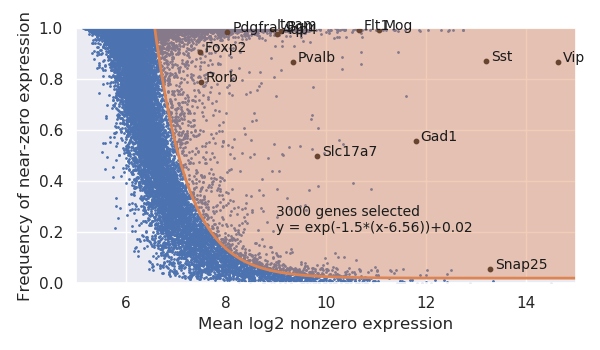

In [3]:
# Feature selection

markerGenes = ['Snap25','Gad1','Slc17a7','Pvalb', 'Sst', 'Vip', 'Aqp4', 
           'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

sns.set()
importantGenesTasic2018 = rnaseqTools.geneSelection(
    tasic2018['counts'], n=3000, threshold=32, 
    markers=markerGenes, genes=tasic2018['genes'])
sns_styleset()

In [9]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

## Main figure with the Tasic dataset

In [5]:
%%time

librarySizes = np.sum(tasic2018['counts'], axis=1)
X = np.log2(tasic2018['counts'][:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

C = tasic2018['clusterNames'].size
clusterMeans = np.zeros((C, X.shape[1]))
for c in range(C):
    clusterMeans[c,:] = np.mean(X[tasic2018['clusters']==c,:], axis=0)
    
pcaInit = X[:,:2] / np.std(X[:,0]) * 0.0001

CPU times: user 1min 44s, sys: 4.92 s, total: 1min 49s
Wall time: 29.2 s


In [6]:
%%time

ZZ = []
Z = X[:,:2]
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity=30, seed=42)
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity=int(X.shape[0]/100), seed=42)
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity=30, initialization=pcaInit)
ZZ.append(Z)
%time Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], initialization=pcaInit, learning_rate=X.shape[0]/12)
ZZ.append(Z)

from sklearn.manifold import MDS
mds = MDS(2, max_iter=100, n_init=1000, random_state=42)
Zmds = mds.fit_transform(clusterMeans)

CPU times: user 612 ms, sys: 92 ms, total: 704 ms
Wall time: 34.1 s
CPU times: user 620 ms, sys: 88 ms, total: 708 ms
Wall time: 1min 14s
CPU times: user 624 ms, sys: 84 ms, total: 708 ms
Wall time: 33.7 s
CPU times: user 624 ms, sys: 84 ms, total: 708 ms
Wall time: 2min 8s
CPU times: user 1min 55s, sys: 1.61 s, total: 1min 57s
Wall time: 4min 59s


In [10]:
%%time

quality = []
for Z in ZZ:
    a,b,c = embedding_quality(X, Z, tasic2018['clusters'])
    quality.append((a,b,c))

CPU times: user 30.9 s, sys: 80 ms, total: 31 s
Wall time: 23.9 s


<IPython.core.display.Javascript object>


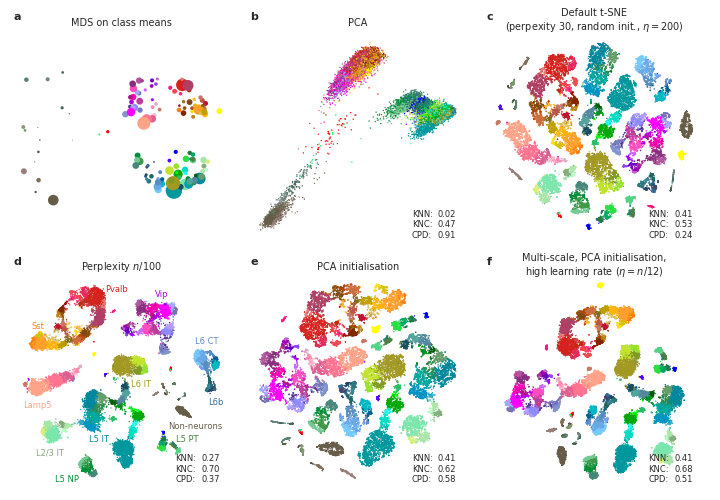

In [12]:
titles = ['MDS on class means', 'PCA', 'Default t-SNE\n(perpexity 30, random init., $\eta=200$)', 'Perplexity $n/100$', 
          'PCA initialisation', 'Multi-scale, PCA initialisation,\nhigh learning rate ($\eta=n/12$)']
letters = 'abcdef'

sns_styleset()
plt.figure(figsize=(7.2, 5))
plt.subplot(231)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Zmds[:,0], Zmds[:,1], c=tasic2018['clusterColors'], edgecolor='none',
            s = np.unique(tasic2018['clusters'], return_counts=True)[1]/10)
plt.title(titles[0], va='center')
plt.xticks([])
plt.yticks([])
plt.text(0, 1.05, letters[0], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

for i,Z in enumerate(ZZ):
    plt.subplot(2,3,2+i)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(Z[:,0], Z[:,1], s=1, c=tasic2018['clusterColors'][tasic2018['clusters']], edgecolor='none',
                rasterized=True)
    plt.title(titles[i+1], va='center')
    plt.text(0.75,.02,'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
    plt.text(0.87,.02,'{:.2f}\n{:.2f}\n{:.2f}'.format(*quality[i]),
             transform=plt.gca().transAxes, fontsize=6)
    plt.text(0, 1.05, letters[i+1], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    
sns.despine(left=True, bottom=True)
plt.tight_layout()

classes = {'Lamp5': [-35, -12, 'Lamp5 Lsp1'],
           'Vip':   [15, 30, 'Vip Rspo4 Rxfp1 Chat'],
           'Pvalb': [-4, 32, 'Pvalb Reln Tac1'],
           'Sst':   [-32, 18, 'Sst Myh8 Fibin'],
           'L2/3 IT': [-30, -30, 'L2/3 IT ALM Sla'],
           'L5 IT': [-10, -25, 'L5 IT ALM Tnc'],
           'L6 IT': [6, -4, 'L6 IT VISp Penk Col27a1'],
           'L5 PT': [23,-25, 'L5 PT ALM Hpgd'],
           'L5 NP': [-23, -40, 'L5 NP VISp Trhr Cpne7'],
           'L6 CT': [30,12, 'L6 CT VISp Nxph2 Wls'],
           'L6b':   [35,-11, 'L6b P2ry12'],
           'Non-neurons': [20,-20, 'Astro Aqp4']}
plt.sca(plt.gcf().get_axes()[3])
for c in classes:
    plt.text(classes[c][0], classes[c][1], c, fontsize=6,
         color=tasic2018['clusterColors'][tasic2018['clusterNames']==classes[c][2]][0])

plt.savefig('figures/tasic-variants.png', dpi=150)
plt.savefig('figures/tasic-variants.pdf', dpi=300)
plt.savefig('figures/tasic-variants-600.pdf', dpi=600)

In [26]:
# High learning rate on its own

Z = fast_tsne(X, perplexity=30, seed=42, learning_rate=X.shape[0]/12)
a,b,c = embedding_quality(X, Z, tasic2018['clusters'], knn=10, knn_classes=10, subsetsize=1000)
print('KNN: {:.2f}\nKNC: {:.2f}\nCPD: {:.2f}'.format(a,b,c))

KNN: 0.45
KNC: 0.55
CPD: 0.26


In [13]:
# PCA of the subsets

firstExcitatoryCluster = np.where(tasic2018['clusterNames']=='L2/3 IT VISp Rrad')[0][0]
lastExcitatoryCluster = np.where(tasic2018['clusterNames']=='L6b Hsd17b2')[0][0]
firstNonneuralCluster = np.where(tasic2018['clusterNames']=='Astro Aqp4')[0][0]
inhNeurons = tasic2018['clusters'] < firstExcitatoryCluster
excNeurons = (tasic2018['clusters'] >= firstExcitatoryCluster) & (tasic2018['clusters'] <= lastExcitatoryCluster)
nonNeurons = tasic2018['clusters'] >= firstNonneuralCluster
subsets = [inhNeurons, excNeurons, nonNeurons]
subsetZs = []
for subsetnum, subset in enumerate(subsets):
    Xsub = np.log2(tasic2018['counts'][:, importantGenesTasic2018][subset,:] / 
                   librarySizes[subset] * 1e+6 + 1)  
    Xsub = np.array(Xsub)
    Xsub = Xsub - Xsub.mean(axis=0)
    U,s,V = np.linalg.svd(Xsub, full_matrices=False)
    U[:,np.sum(V,axis=1)<0] *= -1
    Xsub = np.dot(U, np.diag(s))
    Xsub = Xsub[:, np.argsort(s)[::-1]][:,:50]
    subsetZs.append(Xsub[:,:2])

<IPython.core.display.Javascript object>


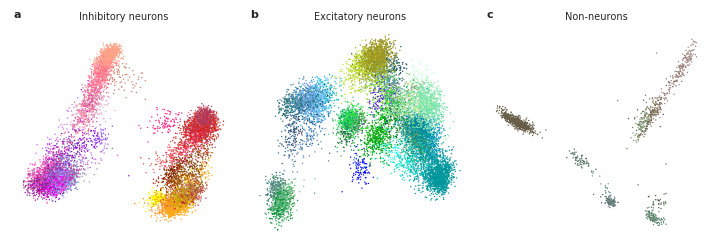

In [14]:
titles = ['Inhibitory neurons', 'Excitatory neurons', 'Non-neurons']
letters = 'abc'
plt.figure(figsize=(7.2, 2.5))
for subsetnum,Z in enumerate(subsetZs):
    plt.subplot(1,3,subsetnum+1)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(Z[:,0], Z[:,1], s=1, edgecolor='none', rasterized=True,
                c=tasic2018['clusterColors'][tasic2018['clusters']][subsets[subsetnum]])
    plt.title(titles[subsetnum])
    plt.text(0, 1.05, letters[subsetnum], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('figures/tasic-subsets-pca.png', dpi=150)
plt.savefig('figures/tasic-subsets-pca.pdf', dpi=300)
plt.savefig('figures/tasic-subsets-pca-600.pdf', dpi=600)

## Exploring parameter space

In [87]:
%%time

# Scanning parameter range...

scan_learning_rates = np.array([200, 500, 1000, 1500, X.shape[0]/12, 2500, 3000])
scan_perplexities   = np.array([30, 100, 200, int(X.shape[0]/100), 300, 400, 500])
scan_random_seeds   = np.array([0, 41, 42, 43]) # 0 means use PCA init

ZZ_scan = {'lr':    np.zeros((X.shape[0], 2, scan_learning_rates.size, scan_random_seeds.size)),
           'perpl': np.zeros((X.shape[0], 2, scan_perplexities.size,   scan_random_seeds.size))}
quality_scan = {'lr':    np.zeros((3, scan_learning_rates.size, scan_random_seeds.size)),
                'perpl': np.zeros((3, scan_perplexities.size,   scan_random_seeds.size))}

for i,lr in enumerate(scan_learning_rates):
    for j,seed in enumerate(scan_random_seeds):
        print('.', end='')
        if seed==0:
            Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], initialization=pcaInit, learning_rate=lr)
        else:
            Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], seed=seed, learning_rate=lr)
        ZZ_scan['lr'][:,:,i,j] = Z
        a,b,c = embedding_quality(X, Z, tasic2018['clusters'])
        quality_scan['lr'][:,i,j] = (a,b,c)

for i,perpl in enumerate(scan_perplexities):
    for j,seed in enumerate(scan_random_seeds):
        print('.', end='')
        if seed==0:
            if perpl>30:
                Z = fast_tsne(X, perplexity_list=[30, perpl], initialization=pcaInit, learning_rate=X.shape[0]/12)
            else:
                Z = fast_tsne(X, perplexity=30, initialization=pcaInit, learning_rate=X.shape[0]/12)
        else:
            if perpl>30:
                Z = fast_tsne(X, perplexity_list=[30, perpl], seed=seed, learning_rate=X.shape[0]/12)
            else:
                Z = fast_tsne(X, perplexity=30, seed=seed, learning_rate=X.shape[0]/12)
        ZZ_scan['perpl'][:,:,i,j] = Z
        a,b,c = embedding_quality(X, Z, tasic2018['clusters'])
        quality_scan['perpl'][:,i,j] = (a,b,c)

print('')        
pickle.dump([ZZ_scan, quality_scan], open('pickles/tasic_scan.pickle', 'wb'))

........................................................
CPU times: user 5min 51s, sys: 5.36 s, total: 5min 56s
Wall time: 1h 47min 37s


<IPython.core.display.Javascript object>


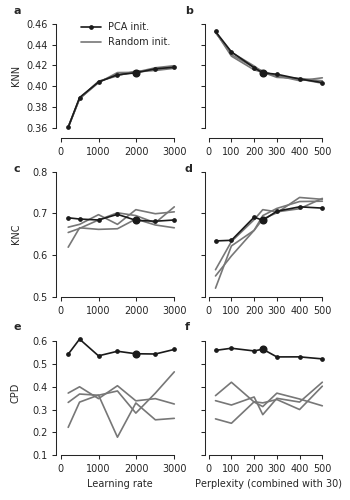

In [15]:
scan_learning_rates = np.array([200, 500, 1000, 1500, X.shape[0]/12, 2500, 3000])
scan_perplexities   = np.array([30, 100, 200, int(X.shape[0]/100), 300, 400, 500])
[ZZ_scan, quality_scan] = pickle.load(open('pickles/tasic_scan.pickle', 'rb'))

sns_styleset()
plt.figure(figsize=(3.5,5))

modes = ['lr','perpl','lr','perpl','lr','perpl']
metrics = [0,0,1,1,2,2]
ylabels = ['KNN', '', 'KNC', '', 'CPD', '']
xlabels = ['','','','','Learning rate', 'Perplexity (combined with 30)']
ylims = [[.35, .47],[.35, .47],[.5, .8],[.5, .8], [.1, .65],[.1, .65]]
yticks = [[.36,.38,.4,.42,.44,.46],[.36,.38,.4,.42,.44,.46],
          [.5,.6,.7,.8],[.5,.6,.7,.8],
          [.1,.2,.3,.4,.5,.6],[.1,.2,.3,.4,.5,.6]]
xticks = [[0,1000,2000,3000], [0,100,200,300,400,500]] * 3

for subpl in range(len(modes)):
    metric = metrics[subpl]    
    mode = modes[subpl]
    
    if mode=='lr':
        x = scan_learning_rates
        defaultX = 4
    else:
        x = scan_perplexities
        defaultX = 3
        
    plt.subplot(3,2,subpl+1)
    l1, = plt.plot(x, quality_scan[mode][metric,:,0], 'k.-')
    plt.plot(x[defaultX], quality_scan[mode][metric,defaultX,0], 'ko')
    for seed in range(1, quality_scan[mode].shape[2]):
        l2, = plt.plot(x, quality_scan[mode][metric,:,seed], '-', color='#777777', zorder=0)

    if subpl==0:
        plt.legend([l1,l2], ['PCA init.', 'Random init.'], frameon=False)

    plt.ylabel(ylabels[subpl])
    plt.xlabel(xlabels[subpl])
    plt.ylim(ylims[subpl])  
    if subpl%2 > 0:
        plt.yticks(yticks[subpl], [])
    else:
        plt.yticks(yticks[subpl])
    plt.xticks(xticks[subpl])

sns.despine(offset={'left':3, 'bottom':0}, trim=True)
plt.gcf().align_labels()
plt.tight_layout()

letters = 'abcdef'
for i in range(6):
    plt.sca(plt.gcf().get_axes()[i])
    plt.text(-0.4 + .2*(i%2), 1, letters[i], transform = plt.gca().transAxes, 
             fontsize=8, fontweight='bold')
    
plt.savefig('figures/scan.png', dpi=150)
plt.savefig('figures/scan.pdf', dpi=300)

## Projecting Cadwell-2016 onto Tasic-2018

Cadwell et al. data files `Data_CortexInterneurons.xlsx` and `IntPhysiologyFinal.mat` can be downloaded from https://github.com/berenslab/patch-seq-rrr/tree/master/cadwellData.

In [17]:
%%time

data = pd.read_excel('../data/cadwell-natbiotech/Data_CortexInterneurons.xlsx', sheet_name='readcounts')
cells  = np.array([int(c[5:-1]) for c in data.values[2,2:-5]])
genes  = np.array([c[1:-1] for c in data.values[4:,1]])
counts = data.values[4:,2:-5].T.astype('float')

from scipy import io
mat = io.loadmat('../data/cadwell-natbiotech/IntPhysiologyFinal.mat')
types = np.array([mat['cell'][0][n][3][0][0] for n in range(len(mat['cell'][0]))])
idxs  = np.array([mat['cell'][0][n][0][0][0] for n in range(len(mat['cell'][0]))])

# Int_44 and Int_45 were removed from the Cadwell et al. due to possible contamination
types = types[(idxs != 44) & (idxs != 45)]
idxs  =  idxs[(idxs != 44) & (idxs != 45)]
counts = counts[[np.where(cells==i)[0][0] for i in idxs], :]

counts = sparse.csr_matrix(counts)
cadwell2016 = {'counts': counts, 'genes': genes, 'clusters': types}

pickle.dump(cadwell2016, open('../data/cadwell-natbiotech/cadwell.pickle', 'wb'))

CPU times: user 15.9 s, sys: 28 ms, total: 16 s
Wall time: 16 s


In [19]:
cadwell2016 = pickle.load(open('../data/cadwell-natbiotech/cadwell.pickle', 'rb'))
print(cadwell2016['counts'].shape)

(46, 21812)


In [5]:
%%time

librarySizes = np.sum(tasic2018['counts'], axis=1)
X = np.log2(tasic2018['counts'][:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

pcaInit = X[:,:2] / np.std(X[:,0]) * 0.0001
Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], 
              initialization=pcaInit, learning_rate=X.shape[0]/12)

CPU times: user 1min 27s, sys: 3.14 s, total: 1min 30s
Wall time: 2min 28s


In [20]:
%%time 

pos, pos_boot = rnaseqTools.map_to_tsne(tasic2018['counts'][:, importantGenesTasic2018],
                                        tasic2018['genes'][importantGenesTasic2018],
                                        cadwell2016['counts'], cadwell2016['genes'],
                                        Z, bootstrap = True, seed=42, knn=10)

Using a common set of 2661 genes.
Bootstrapping.................................................................................................... done
CPU times: user 2min 16s, sys: 34.8 s, total: 2min 51s
Wall time: 1min 4s


In [35]:
%%time

vipcells = np.where(tasic2018['clusters'] < np.where(tasic2018['clusterNames']=='Sst Chodl')[0][0])[0]
np.random.seed(42)
vipcells_sample = vipcells[np.random.choice(vipcells.shape[0], size=100, replace=False)]
vipcells_sample_pos = np.zeros((vipcells_sample.shape[0],2))

for i,v in enumerate(vipcells_sample):
    print('.', end='', flush=True)
    notv = np.arange(tasic2018['counts'].shape[0]) != v
    vipcells_sample_pos[i,:] = rnaseqTools.map_to_tsne(
        tasic2018['counts'][:, importantGenesTasic2018][notv,:],
        tasic2018['genes'][importantGenesTasic2018],
        tasic2018['counts'][:, importantGenesTasic2018][v,:],
        tasic2018['genes'][importantGenesTasic2018], 
        Z[notv,:], knn=10, verbose=0)
print('')

....................................................................................................
CPU times: user 5min 5s, sys: 1min 35s, total: 6min 41s
Wall time: 3min 21s


In [37]:
dists = np.sqrt(np.sum((vipcells_sample_pos - Z[vipcells_sample,:])**2, axis=1))
print(np.percentile(dists, [0,25,50,75,100]))
print(np.mean(dists))
print(np.std(dists))

[ 0.09336824  1.13662255  2.82298292  4.49915647 10.8499006 ]
3.186376841834089
2.4160612435787066


In [24]:
# These cells are not shown in the figure

np.sum(cadwell2016['clusters']==3)

2

<IPython.core.display.Javascript object>


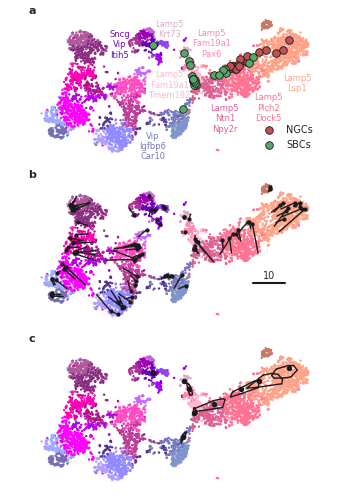

In [36]:
plt.figure(figsize=(3.5,5))
plt.subplot(311)
plt.scatter(Z[vipcells,0], Z[vipcells,1], s=3, edgecolors='none',
            c=tasic2018['clusterColors'][tasic2018['clusters']][vipcells])
a = plt.scatter(pos[cadwell2016['clusters']<=2,0], pos[cadwell2016['clusters']<=2,1], 
                s=30, color='r', edgecolors='k', linewidth=.6)
b = plt.scatter(pos[cadwell2016['clusters']>=4,0], pos[cadwell2016['clusters']>=4,1], 
                s=30, color='g', edgecolors='k', linewidth=.6)
plt.legend([a,b], ['NGCs', 'SBCs'], frameon=False)
plt.gca().set_aspect('equal')
plt.yticks([])
plt.xticks([])

cl = {'Lamp5 Krt73':[-5,7], 'Lamp5 Fam19a1 Pax6':[7,7], 
      'Lamp5 Fam19a1 Tmem182':[-8,-3], 'Lamp5 Ntn1 Npy2r':[5,-10], 
      'Lamp5 Plch2 Dock5':[9,-9], 'Lamp5 Lsp1':[5,-10], 
      'Sncg Vip Itih5':[-10,0], 'Vip Igfbp6 Car10':[-7,-10]}
for c in cl:
    points = Z[tasic2018['clusterNames'][tasic2018['clusters']]==c,:]
    loc = np.median(points, axis=0)
    plt.text(loc[0]+cl[c][0], loc[1]+cl[c][1], '\n'.join(c.split()), fontsize=6,
             color=tasic2018['clusterColors'][tasic2018['clusterNames']==c][0],
             ha='center', va='center')

plt.subplot(312)
plt.scatter(Z[vipcells,0], Z[vipcells,1], s=3, edgecolors='none',
            c=tasic2018['clusterColors'][tasic2018['clusters']][vipcells])
plt.scatter(vipcells_sample_pos[:,0], vipcells_sample_pos[:,1], c='k', s=5)
for i,v in enumerate(vipcells_sample):
    plt.plot([Z[v,0], vipcells_sample_pos[i,0]], [Z[v,1], vipcells_sample_pos[i,1]], 'k', linewidth=1)
plt.gca().set_aspect('equal')
plt.yticks([])
plt.xticks([])
plt.plot([-15,-5],[-11,-11], color='k', linewidth=1.5)
plt.text(-10,-10, '10', fontsize=7, ha='center')

plt.subplot(313)
# plt.axes([0,0,1,.3])
plt.scatter(Z[vipcells,0], Z[vipcells,1], s=3, edgecolors='none',
            c=tasic2018['clusterColors'][tasic2018['clusters']][vipcells])
plt.gca().set_aspect('equal')
plt.yticks([])
plt.xticks([])

from scipy.spatial import ConvexHull
for cell in [8, 32, 40, 1, 28, 18, 4, 20,  10]:
    if cadwell2016['clusters'][cell]<=2:
        col = 'r'
    else:
        col = 'g'
    plt.scatter(pos[cell,0], pos[cell,1], 
            s=10, color='k', edgecolors='k', linewidth=.75)
    points = np.squeeze(pos_boot[cell,:,:]).T
    distances = np.sum((points - pos[cell,:])**2, axis=1)
    ind = np.argsort(distances)[:-5]
    points = points[ind,:]
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color='k', linewidth=1)

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.text(0, 1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')

plt.savefig('figures/cadwell-mapping.png', dpi=150)
plt.savefig('figures/cadwell-mapping.pdf', dpi=300)
plt.savefig('figures/cadwell-mapping-600.pdf', dpi=600)

## Aligning Tasic-2016 and Tasic-2018

The data can be downloaded from http://casestudies.brain-map.org/celltax

In [38]:
%%time

counts = pd.read_csv('../data/tasic-natneuro/genes_counts.csv')
genes = np.array(counts[counts.columns[0]].tolist())
counts = counts.values[:,1:].transpose().astype(float)
counts = sparse.csr_matrix(counts)

rpkm = pd.read_csv('../data/tasic-natneuro/genes_rpkm.csv')
rpkm = rpkm.values[:,1:].transpose().astype(float)
rpkm = sparse.csr_matrix(rpkm)

cellClassification = pd.read_csv('../data/tasic-natneuro/cell_classification.csv')
clusters = np.array([int(a[1:]) for a in cellClassification["primary"].tolist()]) - 1

clusterMetadata = pd.read_csv('../data/tasic-natneuro/cluster_metadata.csv')
clusterColors = np.array(clusterMetadata["vignette_color"].tolist())
clusterNames  = np.array(clusterMetadata["vignette_label"].tolist())

tasic2016 = {'counts': counts, 'rpkm': rpkm, 'genes': genes, 'clusters': clusters, 
             'clusterColors': clusterColors, 'clusterNames': clusterNames}

pickle.dump(tasic2016, open('../data/tasic-natneuro/tasic2016.pickle', 'wb'))

CPU times: user 11.6 s, sys: 1.63 s, total: 13.2 s
Wall time: 14.2 s


In [39]:
tasic2016 = pickle.load(open('../data/tasic-natneuro/tasic2016.pickle', 'rb'))
tasic2016['counts'].shape

(1679, 24057)

Chosen offset: 8.86


<IPython.core.display.Javascript object>


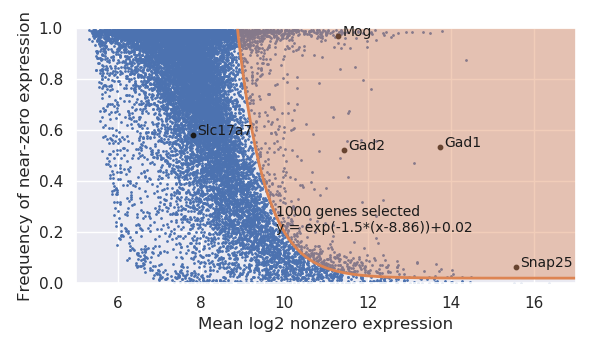

In [40]:
sns.set()
importantGenesTasic2016 = rnaseqTools.geneSelection(tasic2016['counts'], n=1000, threshold=32, 
    markers=['Snap25', 'Gad2', 'Gad1', 'Slc17a7', 'Mog'], genes=tasic2016['genes'])
sns_styleset()

In [41]:
librarySizes = np.sum(tasic2016['counts'], axis=1)
X = np.log2(tasic2016['counts'][:, importantGenesTasic2016] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

Z_2016 = fast_tsne(X, perplexity = 50, initialization = X[:,:2]/np.std(X[:,0])*.0001)

In [42]:
pos = rnaseqTools.map_to_tsne(tasic2016['counts'][:, importantGenesTasic2016],
                              tasic2016['genes'][importantGenesTasic2016],
                              tasic2018['counts'], tasic2018['genes'], Z_2016, knn=10)

Using a common set of 968 genes.
Processing in batches........................ done


In [43]:
visp = np.array([i for i,g in enumerate(tasic2018['clusterNames']) if 'ALM' not in g])
indvisp = np.isin(tasic2018['clusters'], visp)
print('Excluded {} ALM clusters'.format(tasic2018['clusterNames'].size - visp.size))

importantGenesTasic2018_visp = rnaseqTools.geneSelection(tasic2018['counts'][indvisp,:], 
                                                         n=3000, threshold=32, plot=False)

librarySizes = np.sum(tasic2018['counts'][indvisp], axis=1)
X = np.log2(tasic2018['counts'][indvisp,:][:, importantGenesTasic2018_visp] / librarySizes * 1e+6 + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:,np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]
print(X.shape)

Z_aligned_visp = fast_tsne(X, perplexity_list = [30,int(X.shape[0]/100)],
                           initialization = pos[indvisp,:]/np.std(pos[indvisp,0])*0.0001,
                           learning_rate = X.shape[0]/12)

Excluded 23 ALM clusters
Chosen offset: 6.65
(19366, 50)


<IPython.core.display.Javascript object>


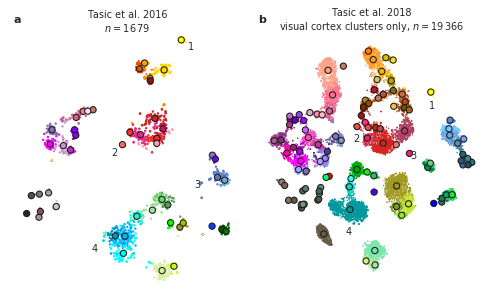

In [44]:
plt.figure(figsize=(5, 3))
plt.subplot(121)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_2016[:,0], Z_2016[:,1], s=3, c=tasic2016['clusterColors'][tasic2016['clusters']],
            edgecolor='none')
clusterMeans = np.zeros((np.unique(tasic2016['clusters']).size, 2))
for cl in range(np.max(tasic2016['clusters'])+1):
    clusterMeans[cl,:] = np.median(Z_2016[tasic2016['clusters']==cl], axis=0)
plt.scatter(clusterMeans[:,0], clusterMeans[:,1], s=20, c=tasic2016['clusterColors'], 
            edgecolor='k', linewidth=.75)
plt.xticks([])
plt.yticks([])
plt.title('Tasic et al. 2016\n' r'$n=1\,679$', va='center')
plt.text(17, 38, '1',fontsize=7)
plt.text(-7, 5,  '2',fontsize=7)
plt.text(19,-5,  '3',fontsize=7)
plt.text(-13,-25,'4',fontsize=7)

plt.subplot(122)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_aligned_visp[:,0], Z_aligned_visp[:,1], s=1, 
            c=tasic2018['clusterColors'][tasic2018['clusters']][indvisp], 
            edgecolor='none', rasterized=True)
clusterMeans = np.zeros((np.unique(tasic2018['clusters']).size, 2))
for cl in visp:
    clusterMeans[cl,:] = np.median(Z_aligned_visp[tasic2018['clusters'][indvisp]==cl], axis=0)
plt.scatter(clusterMeans[visp,0], clusterMeans[visp,1], s=20, c=tasic2018['clusterColors'][visp], 
            edgecolor='k', linewidth=.75)
plt.xticks([])
plt.yticks([])
plt.title('Tasic et al. 2018\nvisual cortex clusters only, ' r'$n=19\,366$', va='center')
plt.text(45, 30, '1',fontsize=7)
plt.text(-8, 7,  '2',fontsize=7)
plt.text(32,-5,  '3',fontsize=7)
plt.text(-13,-58,'4',fontsize=7)

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.text(0, 1.03, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.03, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')

plt.savefig('revision/tasic-vs-tasic.png', dpi=150)
plt.savefig('revision/tasic-vs-tasic.pdf', dpi=300)
plt.savefig('revision/tasic-vs-tasic-600.pdf', dpi=600)

## Supplementary figure: feature selection

<IPython.core.display.Javascript object>


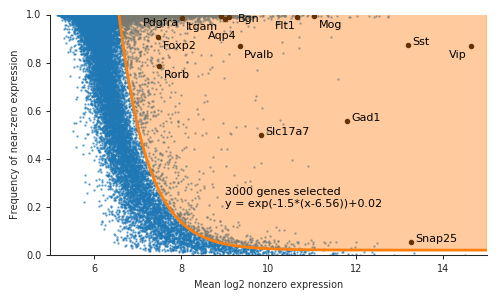

Chosen offset: 6.56


In [3]:
markers = ['Snap25','Gad1','Slc17a7','Pvalb', 'Sst', 'Vip', 'Aqp4', 
           'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

plt.figure(figsize=(5, 3))
rnaseqTools.geneSelection(tasic2018['counts'], n=3000, threshold=32, figsize=None,
              markers=markers, genes=tasic2018['genes'], decay=1.5,
              markeroffsets=[[0,0], [0,0], [0,0], [0,-.05], [0,0],
                    [-.6,-.05], [-0.5,-.08], [0, -.05], [-.9,-0.06], [-1,-0.03],
                    [-.6,-0.05], [0.1,-0.02], [0,-0.05], [0,-0.05]],
              labelsize=8, alpha=.5)
sns.despine()
plt.tight_layout()

plt.savefig('figures/featureSelection.png', dpi=150)
plt.savefig('figures/featureSelection.pdf', dpi=300)
plt.savefig('figures/featureSelection-600.pdf', dpi=600)

## Misc (not shown in the paper)

<IPython.core.display.Javascript object>


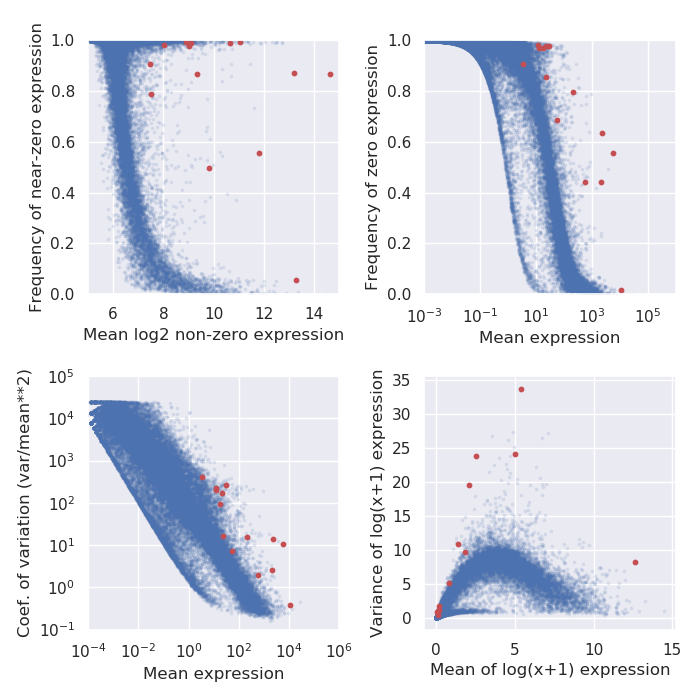

In [55]:
# Different approaches to feature selection...

markerGenes = ['Snap25','Gad1','Slc17a7','Pvalb', 'Sst', 'Vip', 'Aqp4', 
           'Mog', 'Itgam', 'Pdgfra', 'Flt1', 'Bgn', 'Rorb', 'Foxp2']

def sparsevar(X, axis=0):
    squaredX = X.copy()
    squaredX.data = squaredX.data**2
    v = np.array(squaredX.mean(axis=axis)) - np.array(X.mean(axis=axis))**2
    squaredX = []
    return np.squeeze(v)

meanExpr = np.squeeze(np.array(tasic2018['counts'].mean(axis=0)))
zeroRate = 1 - np.squeeze(np.array(np.mean(tasic2018['counts'] > 0, axis=0)))
lowExprRate = 1 - np.squeeze(np.array(np.mean(tasic2018['counts'] > 32, axis=0)))
A = tasic2018['counts'].multiply(tasic2018['counts'] > 32)
A.data = np.log2(A.data)
# meanHighExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-lowExprRate)
meanHighExpr = np.squeeze(np.array(A.mean(axis=0)))
meanHighExpr[lowExprRate<1] /= (1-lowExprRate[lowExprRate<1])
varExpr = sparsevar(tasic2018['counts'])
# cv2 = varExpr/meanExpr**2
cv2 = varExpr
cv2[meanExpr>0] /= meanExpr[meanExpr>0]**2

A = tasic2018['counts'].copy()
A.data = np.log2(A.data + 1)
meanlog2p = np.squeeze(np.array(np.mean(A, axis=0)))
varlog2p  = np.squeeze(np.array(sparsevar(A)))
A = []

sns.set()
plt.figure(figsize=(7,7))

plt.subplot(221)
plt.scatter(meanHighExpr, lowExprRate, s=3, alpha=.1)
for g in markerGenes:
    i = np.where(tasic2018['genes']==g)[0]
    plt.scatter(meanHighExpr[i], lowExprRate[i], s=10, color='r')
plt.xlabel('Mean log2 non-zero expression')
plt.ylabel('Frequency of near-zero expression')
plt.ylim([0,1])
plt.xlim([5,15])

plt.subplot(222)
plt.scatter(meanExpr, zeroRate, s=3, alpha=.1)
for g in markerGenes:
    i = np.where(tasic2018['genes']==g)[0]
    plt.scatter(meanExpr[i], zeroRate[i], s=10, color='r')
plt.xlabel('Mean expression')
plt.ylabel('Frequency of zero expression')
plt.xscale('log')
plt.ylim([0,1])
plt.xlim([10**-3, 10**6])

plt.subplot(223)
plt.scatter(meanExpr, cv2, s=3, alpha=.1)
for g in markerGenes:
    i = np.where(tasic2018['genes']==g)[0]
    plt.scatter(meanExpr[i], cv2[i], s=10, color='r')
plt.xlabel('Mean expression')
plt.ylabel('Coef. of variation (var/mean**2)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-4, 10**6])
plt.ylim([10**-1, 10**5])

plt.subplot(224)
plt.scatter(meanlog2p, varlog2p, s=3, alpha=.1)
for g in markerGenes:
    i = np.where(tasic2018['genes']==g)[0]
    plt.scatter(meanlog2p[i], varlog2p[i], s=10, color='r')
plt.xlabel('Mean of log(x+1) expression')
plt.ylabel('Variance of log(x+1) expression')
plt.tight_layout()

<IPython.core.display.Javascript object>


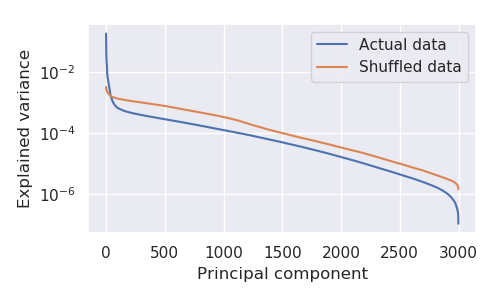

In [56]:
# Dimensionality

librarySizes = np.array(np.sum(tasic2018['counts'], axis=1))
X = np.log2(tasic2018['counts'][:, importantGenesTasic2018] / librarySizes * 1e+6 + 1)
X = np.array(X)
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
for i in range(X.shape[1]):
    X[:,i] = X[np.random.choice(X.shape[0], size=X.shape[0], replace=False), i]
_, sh, _ = np.linalg.svd(X, full_matrices=False)

plt.figure(figsize=(5,3))
plt.plot(s**2/np.sum(s**2),'-')
plt.plot(sh**2/np.sum(sh**2),'-')
plt.legend(['Actual data', 'Shuffled data'])
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.yscale('log')
plt.tight_layout()